In [414]:
# Data generation code adapted from https://m2lines.github.io/L96_demo/notebooks/L96-two-scale-description.html
import matplotlib.pyplot as plt
import numpy as np
import pickle

from L96_model import L96_2t_xdot_ydot, integrate_L96_2t

In [3]:
def s(k, K):
    """A non-dimension coordinate from -1..+1 corresponding to k=0..K"""
    return 2 * (0.5 + k) / K - 1

# Generate data

In [415]:
K = 40  # Number of globa-scale variables X
J = 5  # Number of local-scale Y variables per single global-scale X variable
nt = 5000  # Number of time steps
si = 0.2  # Sampling time interval
dt = 0.005  # Time step
F = 8.0  # Forcing
h = 1.0  # Coupling coefficient
b = 10.0  # ratio of amplitudes
c = 10.0  # time-scale ratio

In [417]:
k = np.arange(K)  # For coordinate in plots
j = np.arange(J * K)  # For coordinate in plots

# Initial conditions
X_init_train = s(k, K) * (s(k, K) - 1) * (s(k, K) + 1) + np.random.normal(0, 0.05, size=(k.shape))
Y_init_train = 0 * s(j, J * K) * (s(j, J * K) - 1) * (s(j, J * K) + 1)

X_init_test = s(k, K) * (s(k, K) - 1) * (s(k, K) + 1) + np.random.normal(0, 0.05, size=(k.shape))
Y_init_test = 0 * s(j, J * K) * (s(j, J * K) - 1) * (s(j, J * K) + 1)

# "Run" model
X_train, Y_train, t = integrate_L96_2t(X_init_train, Y_init_train, si, nt, F, h, b, c, dt=dt)
X_test, Y_test, t = integrate_L96_2t(X_init_test, Y_init_test, si, nt, F, h, b, c, dt=dt)

In [ ]:
with open("train_traj.p", 'rb') as file:
    train_data = pickle.load(file)
    
with open("test_traj.p", 'rb') as file:
    test_data = pickle.load(file)
    
X_train = train_data['slow']
X_test = test_data['slow']
t = train_data['t']

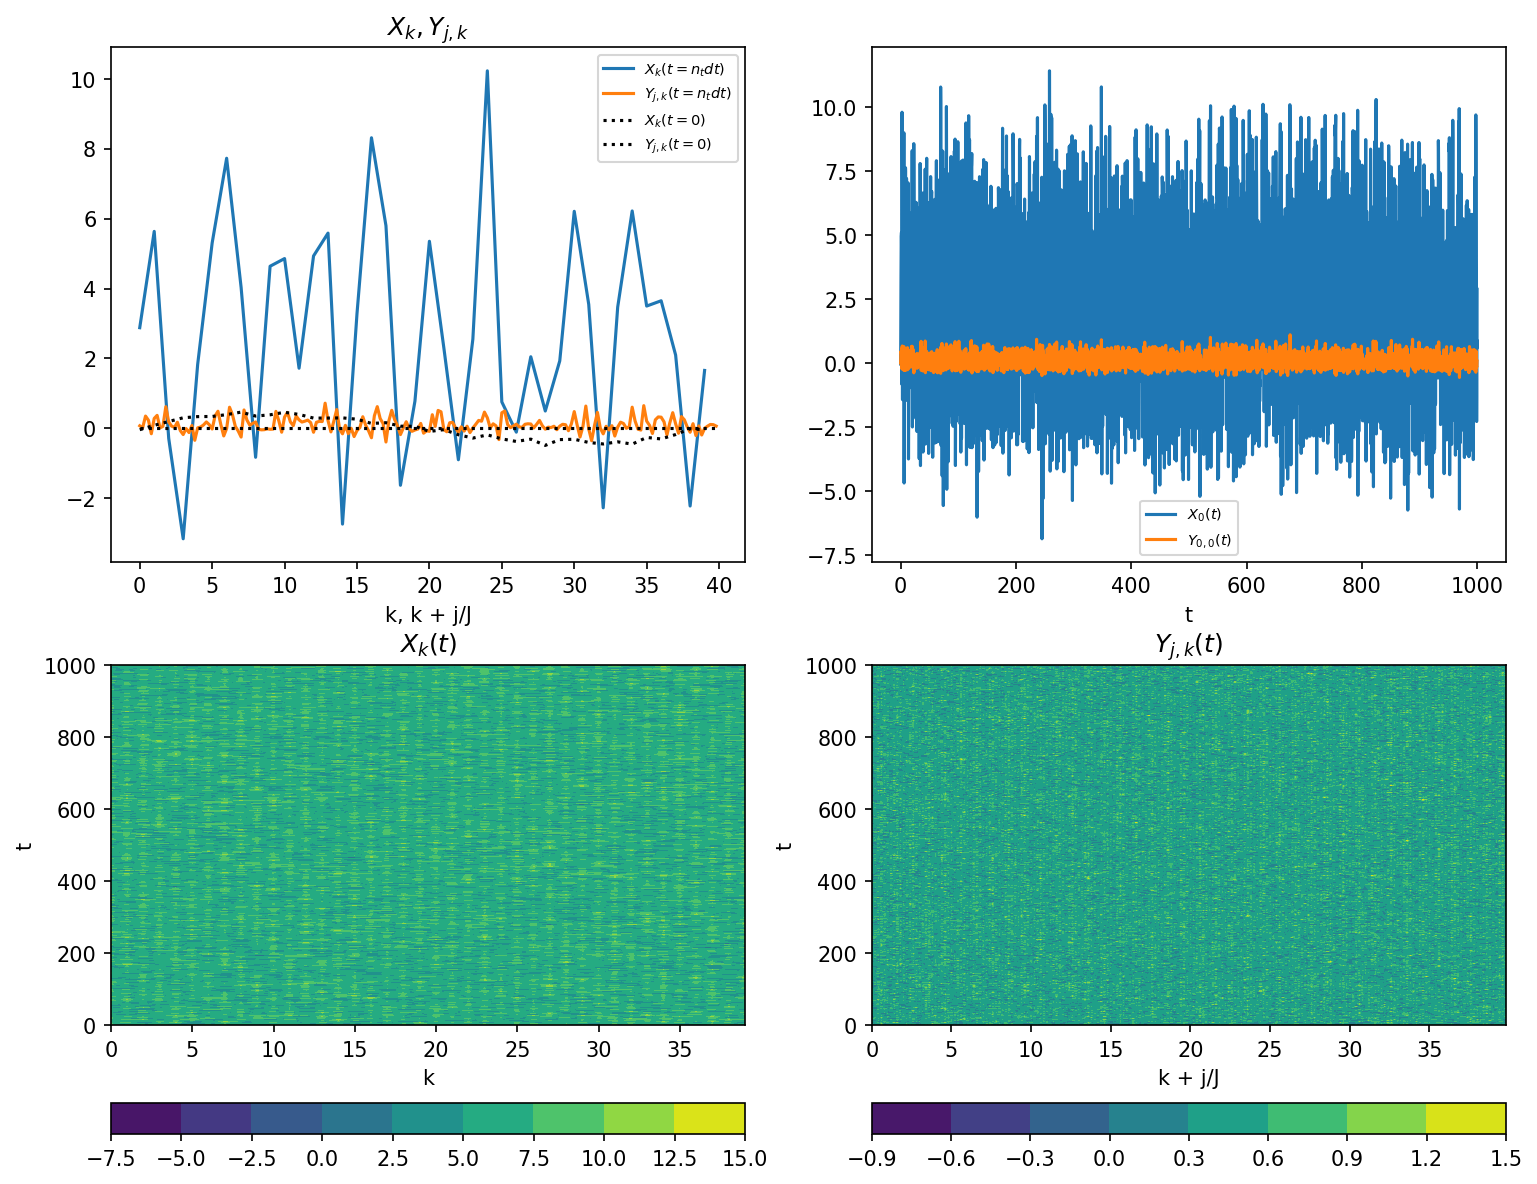

In [418]:
plt.figure(figsize=(12, 10), dpi=150)
plt.subplot(221)

# Snapshot of X[k]
plt.plot(k, X_train[-1], label="$X_k(t=n_t dt)$")
plt.plot(j / J, Y_train[-1], label="$Y_{j,k}(t=n_t dt)$")
plt.plot(k, X_init_train, "k:", label="$X_k(t=0)$")
plt.plot(j / J, Y_init_train, "k:", label="$Y_{j,k}(t=0)$")
plt.legend(fontsize=7)
plt.xlabel("k, k + j/J")
plt.title("$X_k, Y_{j,k}$")
plt.subplot(222)

# Sample time-series X[0](t), Y[0](t)
plt.plot(t, X_train[:, 0], label="$X_0(t)$")
plt.plot(t, Y_train[:, 0], label="$Y_{0,0}(t)$")
plt.legend(fontsize=7)
plt.xlabel("t")
plt.subplot(223)

# Full model history of X
plt.contourf(k, t, X_train)
plt.colorbar(orientation="horizontal")
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$")
plt.subplot(224)

# Full model history of Y
plt.contourf(j / J, t, Y_train)
plt.colorbar(orientation="horizontal")
plt.xlabel("k + j/J")
plt.ylabel("t")
plt.title("$Y_{j,k}(t)$");

# Running the ENKF

In [419]:
# slow forward model
from L96_model import integrate_L96_1t

In [420]:
import scipy

In [506]:
noise_scale = 1.0

inflate = False
inflation = 1.005

model_noise = 0.1
N_particles = 50

X_train_noisy = X_train + np.random.normal(scale=noise_scale, size=X_train.shape)
X_test_noisy = X_test + np.random.normal(scale=noise_scale, size=X_test.shape)

localize = True
localization_lengthscale = 20
localization_matrix = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        localization_matrix[i,j] = np.exp(-abs(i-j)**2 / localization_lengthscale)

In [500]:
train_data = {"slow" : X_train, "obs" : X_train_noisy, "fast" : Y_train, "time" : t}
test_data = {"slow" : X_test, "obs" : X_test_noisy, "fast" : Y_test, "time" : t}

with open("train_traj_noise" + str(noise_scale).replace('.', '_') + ".p", 'wb') as file:
    pickle.dump(train_data, file)
    
with open("test_traj_noise" + str(noise_scale).replace('.', '_') + ".p", 'wb') as file:
    pickle.dump(test_data, file)

### Training trajectory

In [507]:
prediction = []
analysis = []
correction = []

particles = X_train[0] + np.random.normal(scale=1.0, size=(N_particles, K))

for i in range(nt):
    # propagate particles one step forward
    for j in range(N_particles):
        particles[j] = integrate_L96_1t(particles[j], F, si, 1)[0][-1] + np.random.normal(scale=model_noise, size=K)

    if inflate:
        mean_pred = np.broadcast_to(np.mean(particles, axis=1, keepdims=True), particles.shape)
        particles = mean_pred + inflation * (particles - mean_pred)
        
    prediction.append(np.copy(particles))

    # Compute the empirical covariance matrix
    cov = np.cov(particles.T)
    
    if localize:
        cov = localization_matrix * cov

    y_train = X_train_noisy[i+1]
    
    # Draw observational noise
    noise = np.random.normal(scale=noise_scale, size=particles.shape)

    increment = y_train - noise - particles
    
    a = cov@scipy.linalg.solve(cov + (noise_scale**2)*np.eye(K), increment.T, assume_a='pos')
    correction.append(a.T)    

    particles = particles + a.T
    analysis.append(np.copy(particles))
    
analysis = np.array(analysis)
prediction = np.array(prediction)
correction = np.array(correction)

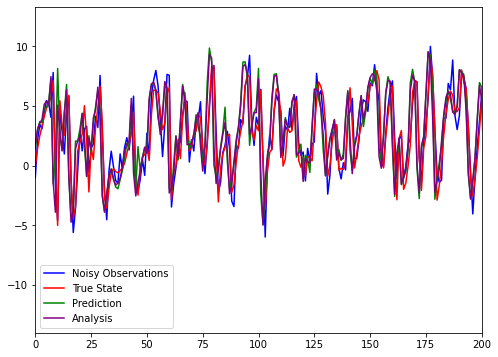

In [508]:
dim = -1
plt.figure(figsize=(8,6))
plt.plot(X_train_noisy[:, dim], label = 'Noisy Observations', color = 'blue')
plt.plot(X_train[:, dim], label = 'True State', color = 'red')
plt.plot(np.mean(prediction[:, :, dim], axis = 1), label = 'Prediction', color = 'green')
plt.plot(np.mean(analysis[:, :, dim], axis = 1), label = 'Analysis', color = 'purple')
plt.legend()
plt.xlim(0, 200)
plt.show()

### Testing trajectory

In [509]:
prediction_test = []
analysis_test = []
correction_test = []

particles_test = X_test[0] + np.random.normal(scale=1.0, size=(N_particles, K))

for i in range(nt):
    # propagate particles one step forward
    for j in range(N_particles):
        particles_test[j] = integrate_L96_1t(particles_test[j], F, si, 1)[0][-1] + np.random.normal(scale=model_noise, size=K)

    if inflate:
        mean_pred = np.broadcast_to(np.mean(particles, axis=1, keepdims=True), particles.shape)
        particles = mean_pred + inflation * (particles - mean_pred)
        
    prediction_test.append(np.copy(particles_test))

    # Compute the empirical covariance matrix
    cov = np.cov(particles_test.T)
    
    if localize:
        cov = localization_matrix * cov

    y_test = X_test_noisy[i+1]
    
    # Draw observational noise
    noise = np.random.normal(scale=noise_scale, size=particles_test.shape)

    increment = y_test - noise - particles_test
    
    a = cov@scipy.linalg.solve(cov + (noise_scale**2)*np.eye(K), increment.T, assume_a='pos')
    correction_test.append(a.T)    

    particles_test = particles_test + a.T
    analysis_test.append(np.copy(particles_test))
    
analysis_test = np.array(analysis_test)
prediction_test = np.array(prediction_test)
correction_test = np.array(correction_test)

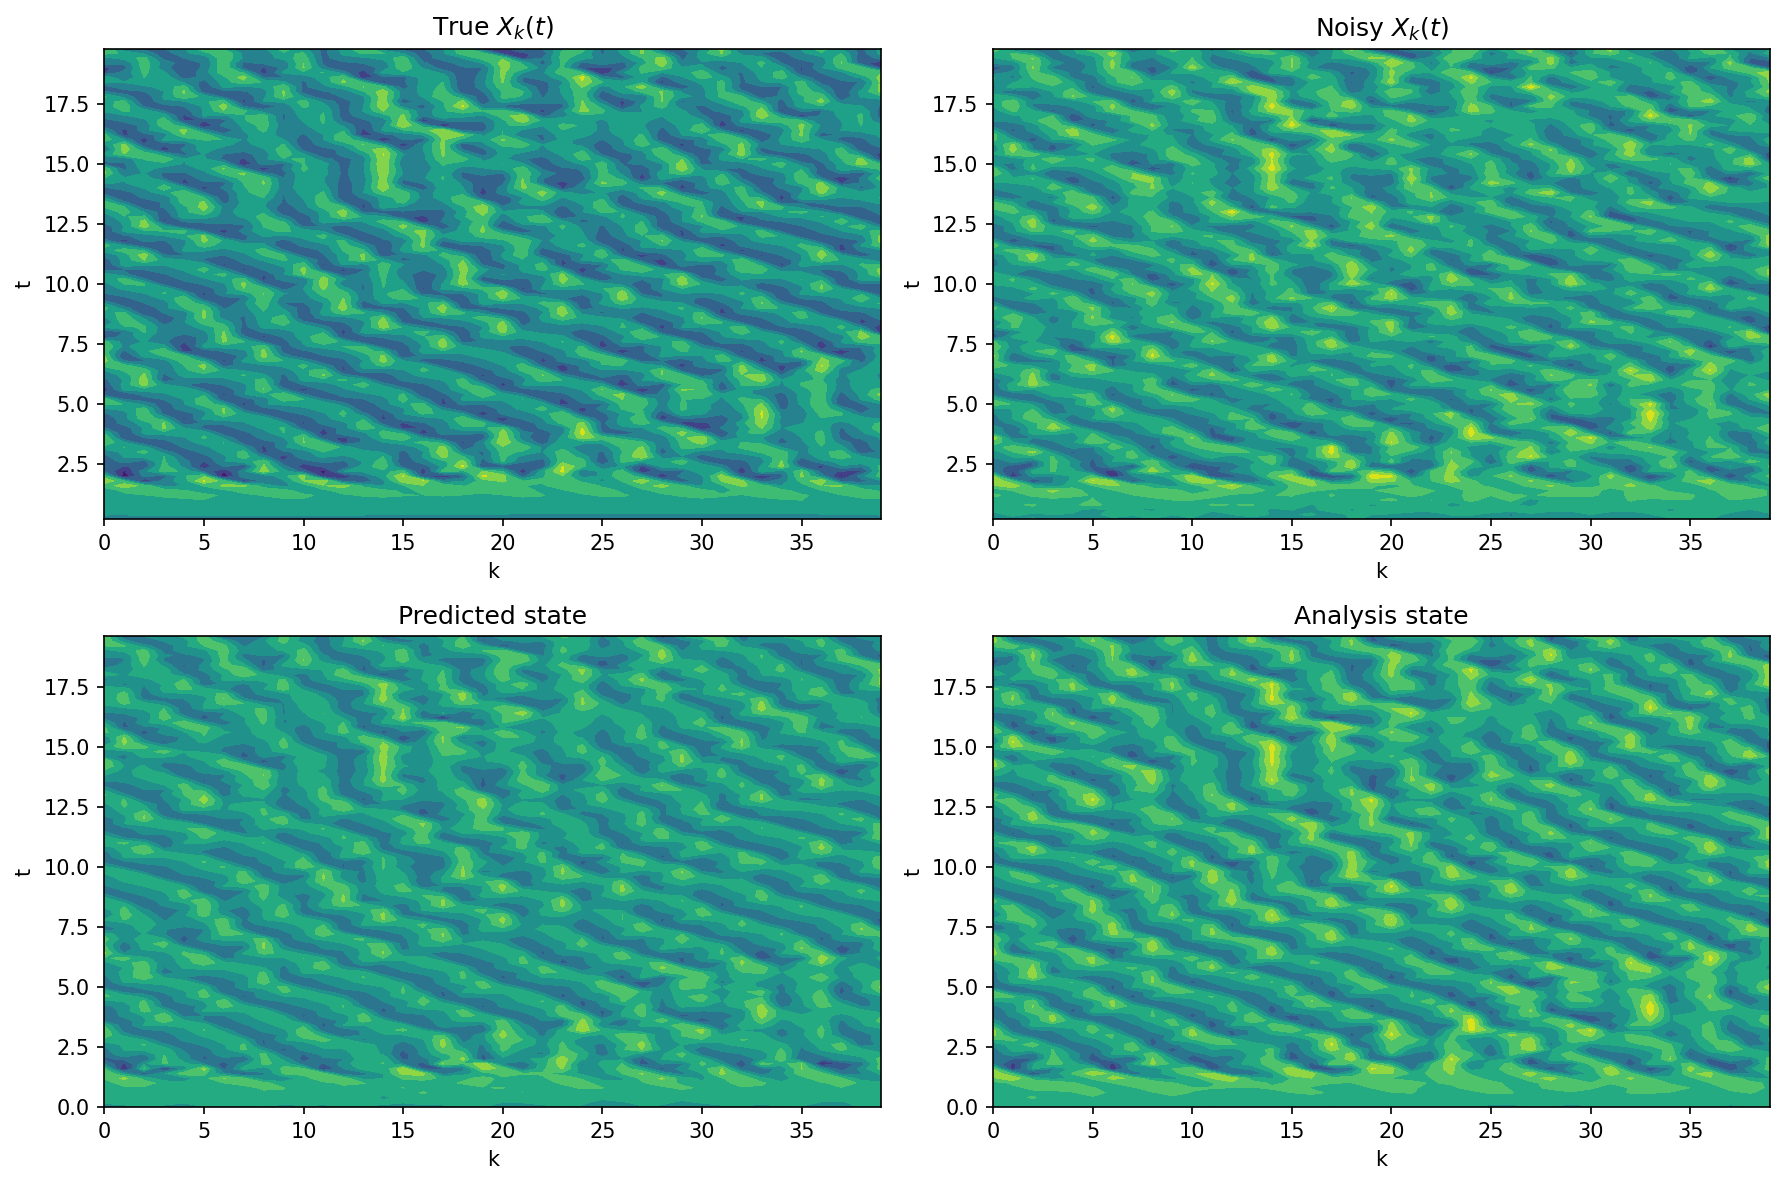

In [510]:
plt.figure(figsize=(12, 8), dpi=150)

time_cutoff = 100

# True X
plt.subplot(221)
plt.contourf(k, t[1:time_cutoff], X_test[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("True $X_k(t)$")

# Noisy observations X_noisy
plt.subplot(222)
plt.contourf(k, t[1:time_cutoff], X_test_noisy[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("Noisy $X_k(t)$")

# Analysis
plt.subplot(223)
mean_prediction = np.mean(prediction_test, axis = 1)
plt.contourf(k, t[:time_cutoff-1], mean_prediction[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("Predicted state")

# Prediction
plt.subplot(224)
mean_analysis = np.mean(analysis_test, axis = 1)
plt.contourf(k, t[:time_cutoff-1], mean_analysis[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("Analysis state")

plt.tight_layout()
plt.show()

# Neural network training

In [511]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [512]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(K, 4*K),
            nn.ReLU(),
            nn.Linear(4*K, 4*K),
            nn.ReLU(),
            nn.Linear(4*K, K),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [513]:
inputs = torch.tensor(prediction, dtype=torch.float32)
outputs = torch.tensor(correction, dtype=torch.float32)

In [514]:
model = NeuralNetwork()
loss = nn.MSELoss()

# Initialize the optimizer to be adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
N = 3

loss_hist = []
# train the model
for epoch in range(N):
    for i in range(N_particles):
        optimizer.zero_grad()
        outputs_pred = model(inputs[:, i, :])
        loss_value = loss(outputs_pred, outputs[:, i,:])
        loss_value.backward()
        optimizer.step()

        loss_hist.append(loss_value.item())
    print(f"Epoch {epoch}, Loss {loss_value}")

Epoch 0, Loss 0.4344604015350342
Epoch 1, Loss 0.4211621880531311
Epoch 2, Loss 0.40797922015190125


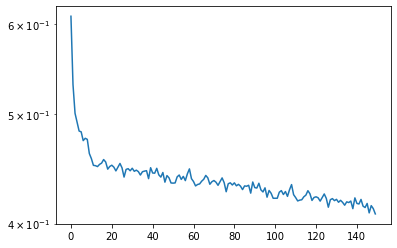

In [515]:
plt.plot(loss_hist)
plt.yscale('log')

# Evaluate ENKF + NN on test set

In [516]:
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=40, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=160, bias=True)
    (3): ReLU()
    (4): Linear(in_features=160, out_features=40, bias=True)
  )
)

In [517]:
prediction_nn = []
analysis_nn = []
correction_nn = []

particles = X_test[0] + np.random.normal(scale=1.0, size=(N_particles, K))

for i in range(nt):
    # propagate particles one step  forward
    for j in range(N_particles):
        particles[j] = integrate_L96_1t(particles[j], F, si, 1)[0][-1] + np.random.normal(scale=model_noise, size=K)

    particles = particles + model(torch.tensor(particles, dtype=torch.float32)).detach().numpy()
    
    if inflate:
        mean_pred = np.broadcast_to(np.mean(particles, axis=1, keepdims=True), particles.shape)
        particles = mean_pred + inflation * (particles - mean_pred)
        
    prediction_nn.append(np.copy(particles))

    # Compute the empirical covariance matrix
    cov = np.cov(particles.T)
    
    if localize:
        cov = localization_matrix * cov

    y = X_test_noisy[i+1]
    
    # Draw observational noise
    noise = np.random.normal(scale=noise_scale, size=particles.shape)

    increment = y - noise - particles
    
    a = cov@scipy.linalg.solve(cov + (noise_scale**2)*np.eye(K), increment.T, assume_a='pos')
        
    particles = particles + a.T #+ model(torch.tensor(particles, dtype=torch.float32)).detach().numpy()
    analysis_nn.append(np.copy(particles))
    correction_nn.append(a.T)
    
    
analysis_nn = np.array(analysis_nn)
prediction_nn = np.array(prediction_nn)
correction_nn = np.array(correction_nn)

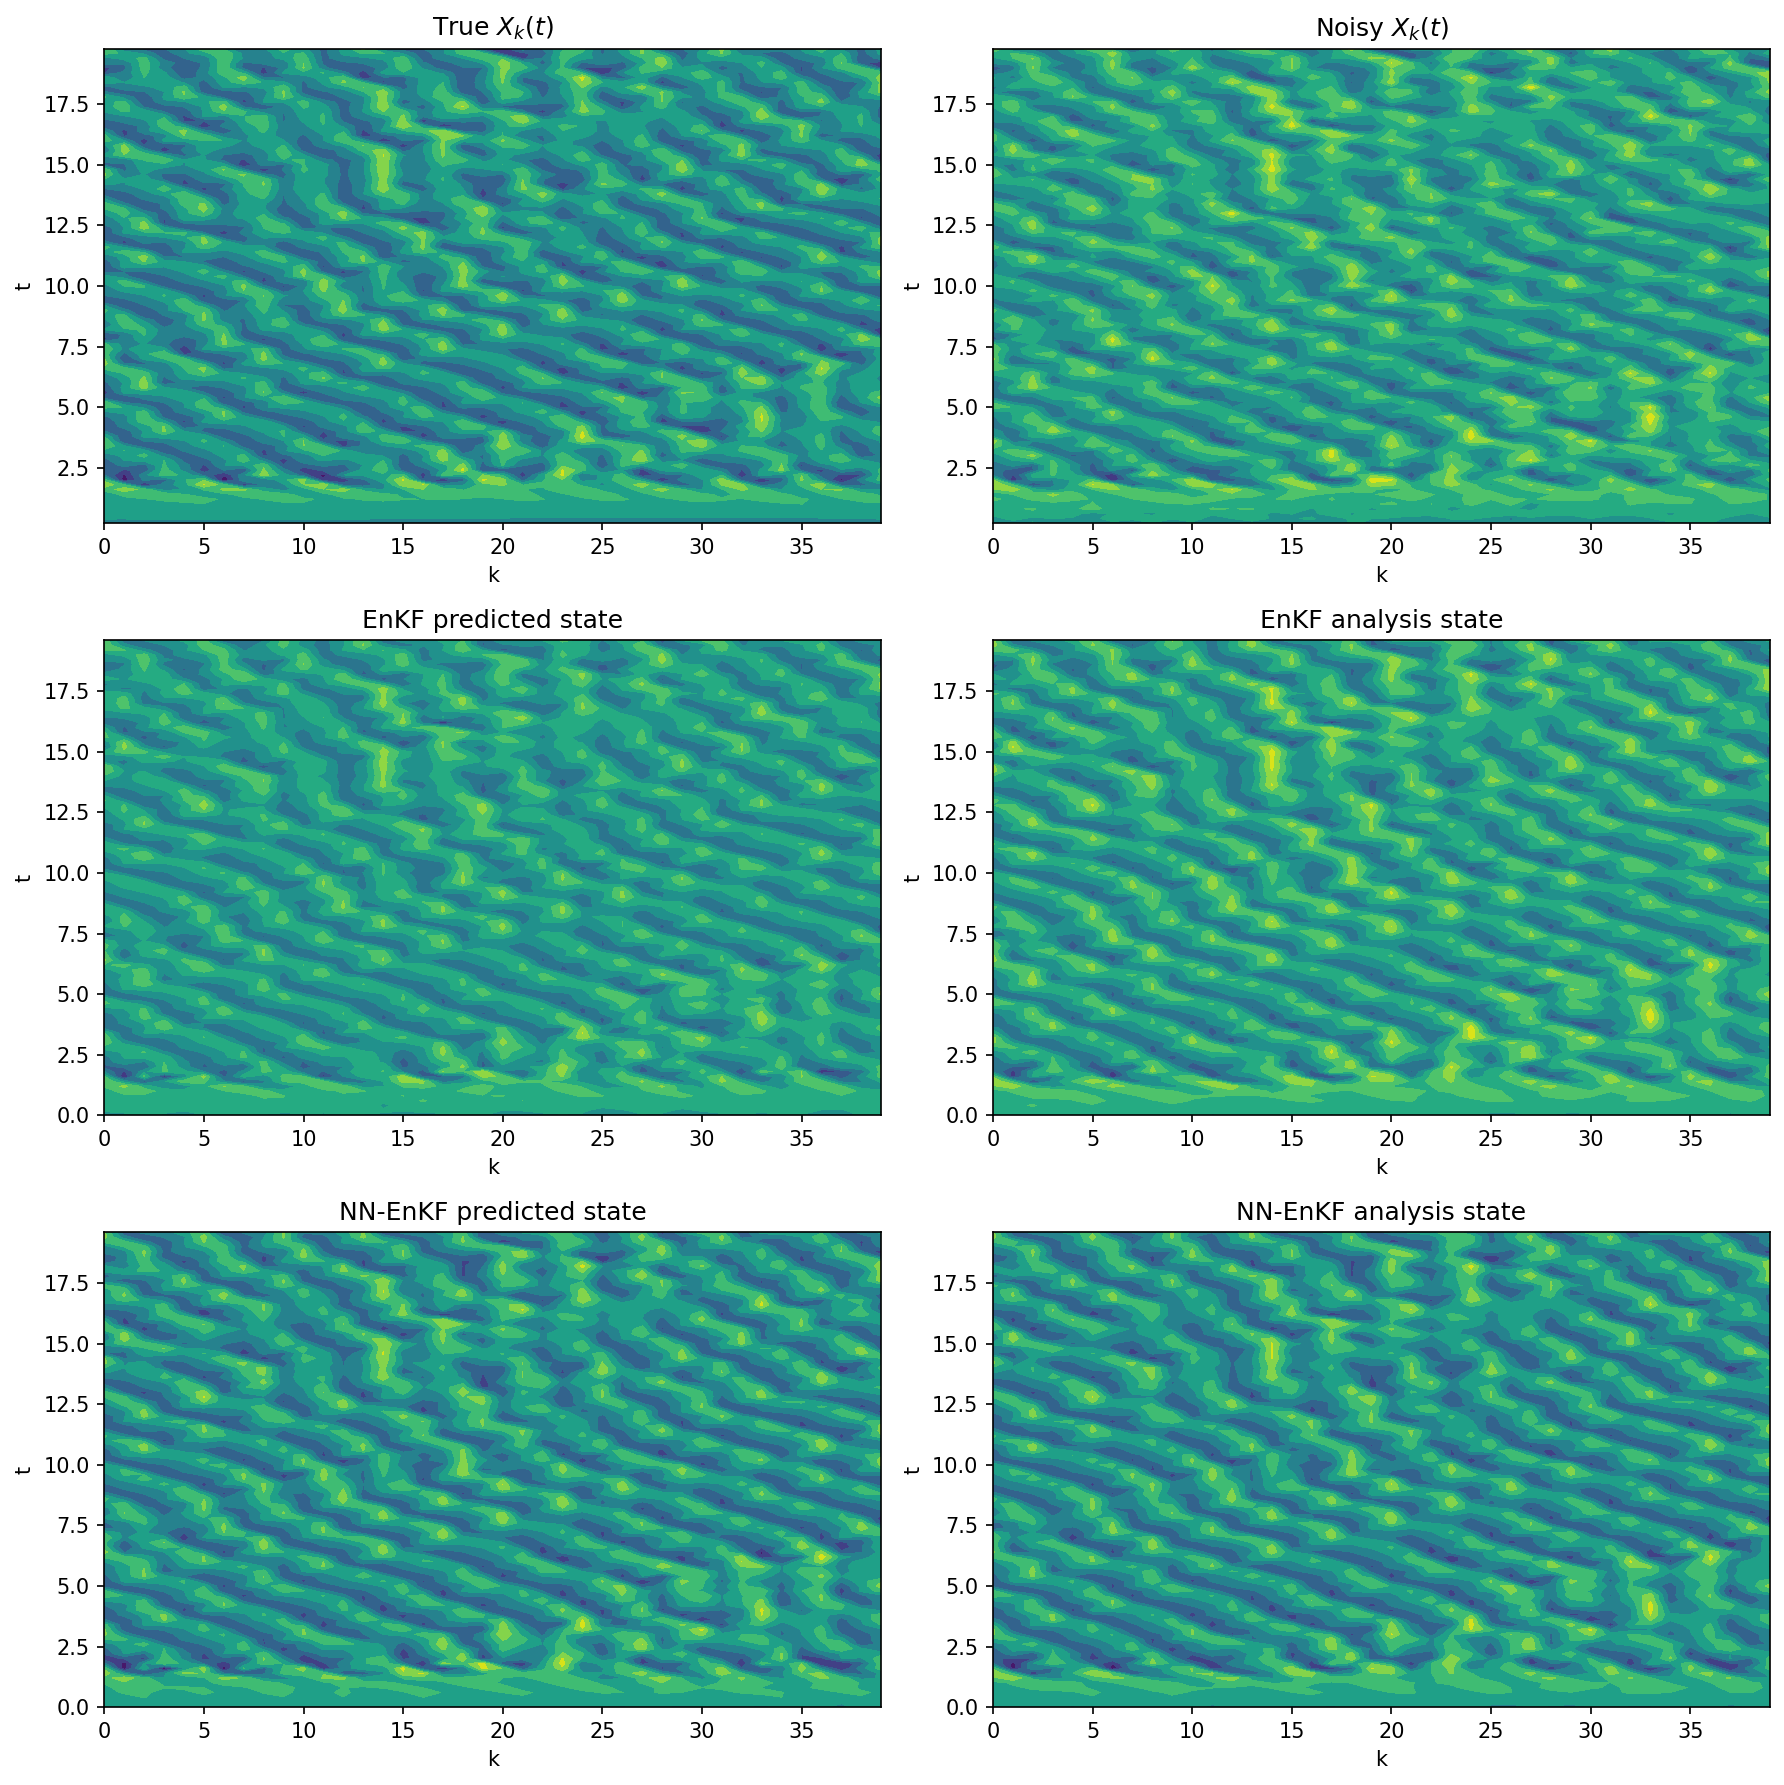

In [521]:
plt.figure(figsize=(12, 12), dpi=150)

time_cutoff = 100

# True X
plt.subplot(321)
plt.contourf(k, t[1:time_cutoff], X_test[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("True $X_k(t)$")

# Noisy observations X_noisy
plt.subplot(322)
plt.contourf(k, t[1:time_cutoff], X_test_noisy[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("Noisy $X_k(t)$")

# Analysis EnKF
plt.subplot(323)
mean_prediction = np.mean(prediction_test, axis = 1)
plt.contourf(k, t[:time_cutoff-1], mean_prediction[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("EnKF predicted state")

# Prediction EnKF
plt.subplot(324)
mean_analysis = np.mean(analysis_test, axis = 1)
plt.contourf(k, t[:time_cutoff-1], mean_analysis[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("EnKF analysis state")

# Analysis EnKF
plt.subplot(325)
mean_prediction = np.mean(prediction_nn, axis = 1)
plt.contourf(k, t[:time_cutoff-1], mean_prediction[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("NN-EnKF predicted state")

# Prediction EnKF
plt.subplot(326)
mean_analysis = np.mean(analysis_nn, axis = 1)
plt.contourf(k, t[:time_cutoff-1], mean_analysis[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("NN-EnKF analysis state")

plt.tight_layout()
plt.show()

In [497]:
dim = -1
plt.plot(X_noisy[:, dim], label = 'Noisy Observations', color = 'blue')
plt.plot(X[:, dim], label = 'True State', color = 'red')
plt.plot(np.mean(prediction_nn[:, :, dim], axis = 1), label = 'Prediction', color = 'green')
plt.plot(np.mean(analysis_nn[:, :, dim], axis = 1), label = 'Analysis', color = 'purple')
plt.legend()
plt.xlim(0, 200)

NameError: name 'X_noisy' is not defined

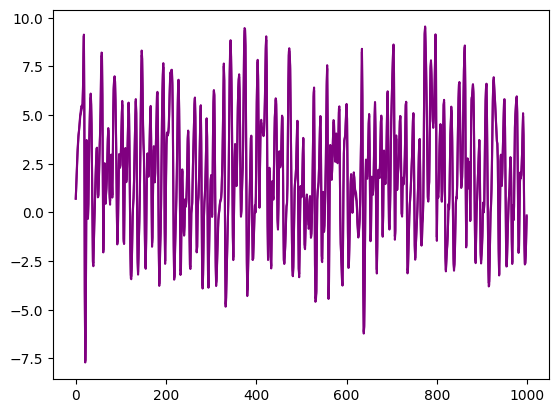

In [35]:
plt.plot(np.mean(analysis_nn[:, :, dim], axis = 1), label = 'Analysis', color = 'purple')
plt.plot(np.mean(analysis[:, :, dim], axis = 1), label = 'Analysis', color = 'purple')

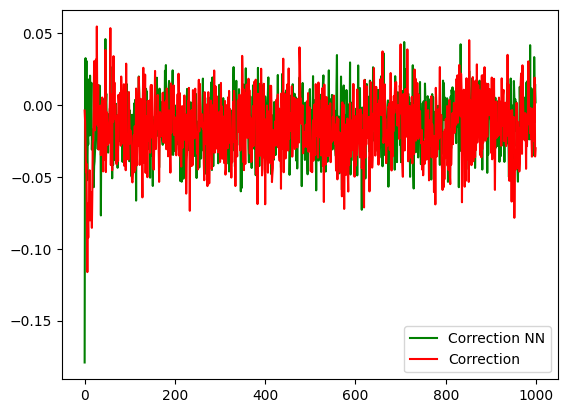

In [36]:
plt.plot(np.mean(correction_nn[:, dim, :], axis = -1), label = 'Correction NN', color = 'green')
plt.plot(np.mean(correction[:, dim, :], axis = -1), label = 'Correction', color = 'red')
plt.legend()

In [498]:
# Compute the RMSE between the true state and the analysis

np.mean((np.mean(analysis_test, axis = 1) - X_test[1:])**2)

0.018851869968200284

In [499]:
np.mean((np.mean(analysis_nn, axis = 1) - X_test[1:])**2)

0.015282470987432